In [1]:
import os
os.chdir('../')

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
model_path = 'runs/20241115-172401'

def get_models(model_path):
    models = os.listdir(model_path)
    # Number of steps from file name
    models = [(f, int(f.split('_')[1].replace('.pt',''))) for f in models if f.endswith(".pt")]
    # Sort on the number of steps
    models.sort(key=lambda x: x[1])
    return models

models = get_models(model_path)

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
def plot_evolution(concept, scores):
    # fig = plt.figure(figsize=set_size_and_get_figsize(2.5))
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.text2D(0.5, 0.9, f'{concept.plot_name}', transform=ax.transAxes, ha='center', fontsize=30)
    ax.view_init(elev=25, azim=190)
    
    ax.plot_surface(np.log10(scores['x']+1), scores['y'], np.maximum(0.001, scores['z']), vmin=0, vmax=1, cmap='plasma')
    ax.set_xlabel('Checkpoint', labelpad=15, fontsize=22)
    ax.xaxis.set_tick_params(pad=10, labelsize=15)
    ax.set_xticks(np.log10([1, 10**2, 10**4, 10**6]))
    ax.set_xticklabels(['$0$', '$10^2$', '$10^4$', '$10^6$'])
    for tick in ax.get_xticklabels():
        tick.set_verticalalignment('bottom')
    
    ax.set_ylabel('Layer', labelpad=10, fontsize=22)
    ax.set_yticks(np.unique(scores['y']))
    ytick_labels = [str(int(y)+1) for y in np.unique(scores['y'])] # plus 1 to start at 0 and not -1 to respect notation
    ax.set_yticklabels(ytick_labels)
    ax.yaxis.set_tick_params(pad=5, labelsize=15)

    ax.set_zlabel('Score', labelpad=10, fontsize=22)
    ax.set_zticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.zaxis.set_tick_params(pad=5, labelsize=15)

    plt.savefig(f'figures/concept evolution/{concept.name}.png', bbox_inches='tight', pad_inches=0.35)
    plt.show()

In [5]:
def get_scores(concept, models, layers):
    scores = {'x': [], 'y': [], 'z': []}
    
    for model_name, step in models:
        model_path_full = os.path.join(model_path, model_name)
        model = QNetwork(model_path=model_path_full)
        
        # Get activations for training data
        _, acts_dict_train = model(train_obs, return_acts=True)
        # Get activations for testing data
        _, acts_dict_test = model(test_obs, return_acts=True)
        
        for l in layers:
            if l == -1:
                # Use raw observations
                x_data_train = train_obs.view(train_obs.shape[0], -1).cpu().numpy()
                y_data_train = concept.train_values.astype(int)  # Ensure labels are integers
                x_data_test = test_obs.view(test_obs.shape[0], -1).cpu().numpy()
                y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
                # Normalize the input data by dividing by the maximum value
                input_max = train_obs.max()
                x_data_train /= input_max
                x_data_test /= input_max
            else:
                # Prepare training data
                x_data_train = acts_dict_train[l].flatten(start_dim=1).cpu().numpy()
                y_data_train = concept.train_values.astype(int)  # Ensure labels are integers
                
                # Prepare testing data
                x_data_test = acts_dict_test[l].flatten(start_dim=1).cpu().numpy()
                y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
            
            # Train logistic regression classifier
            lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
            lr.fit(x_data_train, y_data_train)
            
            # Evaluate the classifier
            score = max(0, 2 * lr.score(x_data_test, y_data_test) - 1)
            
            # Collect the scores
            scores['x'].append(step)
            scores['y'].append(l)
            scores['z'].append(score)
    
    return scores

In [16]:
def plot_evolution(concept, scores):
    # Extract unique checkpoints and layers
    unique_checkpoints = sorted(set(scores['x']))
    unique_layers = sorted(set(scores['y']))

    # Create a meshgrid for checkpoints and layers
    X, Y = np.meshgrid(unique_checkpoints, unique_layers)

    # Initialize Z with NaNs
    Z = np.full(X.shape, np.nan)

    # Populate Z with scores
    for checkpoint, layer, score in zip(scores['x'], scores['y'], scores['z']):
        # Find the corresponding indices in the grid
        try:
            x_idx = unique_checkpoints.index(checkpoint)
            y_idx = unique_layers.index(layer)
            Z[y_idx, x_idx] = score
        except ValueError:
            # If checkpoint or layer is not found, skip
            continue

    # Handle any missing data by interpolation or masking
    # For simplicity, we'll use nearest values to fill NaNs
    from scipy.interpolate import griddata

    # Identify indices where Z is NaN
    nan_mask = np.isnan(Z)
    if np.any(nan_mask):
        # Coordinates of known data points
        known_x, known_y = X[~nan_mask], Y[~nan_mask]
        known_z = Z[~nan_mask]

        # Coordinates where data is missing
        missing_x, missing_y = X[nan_mask], Y[nan_mask]

        # Interpolate missing values
        interpolated_z = griddata(
            points=(known_x, known_y),
            values=known_z,
            xi=(missing_x, missing_y),
            method='nearest'
        )

        # Fill the missing Z values
        Z[nan_mask] = interpolated_z

    # Convert X to log scale as per original code
    X_log = np.log10(X + 1)

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Add title
    ax.text2D(0.5, 0.95, f'{concept.plot_name}', transform=ax.transAxes, ha='center', fontsize=20)

    # Plot the surface
    surf = ax.plot_surface(
        X_log, Y, Z,
        cmap='plasma',
        edgecolor='none',
        alpha=0.8,
        rstride=1,
        cstride=1,
        antialiased=True
    )

    # Customize axis labels
    ax.set_xlabel('Checkpoint (log scale)', fontsize=15, labelpad=10)
    ax.set_ylabel('Layer', fontsize=15, labelpad=10)
    ax.set_zlabel('Score', fontsize=15, labelpad=10)

    # Customize ticks
    ax.set_xticks(np.log10([1, 10**2, 10**4, 10**6]))
    ax.set_xticklabels(['$0$', '$10^2$', '$10^4$', '$10^6$'], fontsize=12)
    ax.set_yticks(unique_layers)
    ax.set_yticklabels([str(int(y)) for y in unique_layers], fontsize=12)
    ax.set_zlim(0, 1)
    ax.set_zticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.zaxis.set_tick_params(labelsize=12)

    # Rotate the view
    ax.view_init(elev=25, azim=190)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Ensure the directory exists
    output_dir = 'figures/concept_evolution/'
    os.makedirs(output_dir, exist_ok=True)

    # Save the figure
    plt.savefig(f'{output_dir}{concept.name}_3d_plot.png', bbox_inches='tight', pad_inches=0.35)
    plt.show()

Loaded model: 20241115-172401-0
Loaded model: 20241115-172401-10


/home/jacob/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Loaded model: 20241115-172401-31


/home/jacob/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Loaded model: 20241115-172401-100


/home/jacob/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Loaded model: 20241115-172401-316


/home/jacob/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Loaded model: 20241115-172401-1000
Loaded model: 20241115-172401-3162
Loaded model: 20241115-172401-10000
Loaded model: 20241115-172401-31622
Loaded model: 20241115-172401-100000
Loaded model: 20241115-172401-316227
Loaded model: 20241115-172401-1000000
Loaded model: 20241115-172401-1990000


/tmp/ipykernel_32306/1037766100.py:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


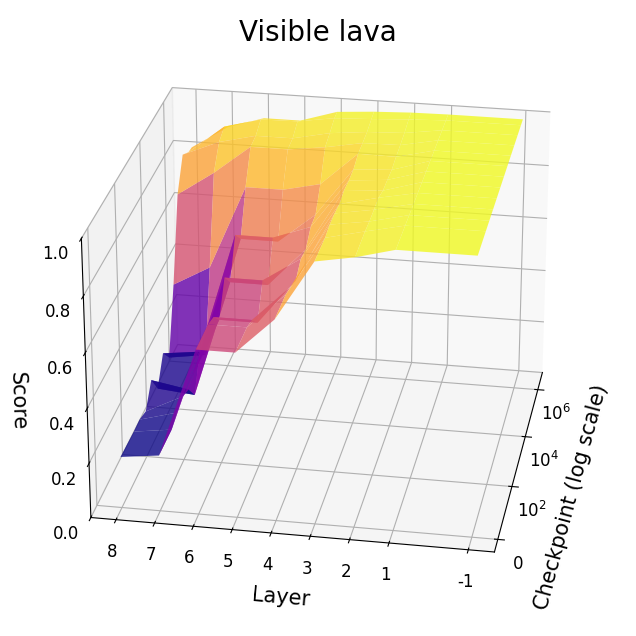

In [21]:
concept = concept_instances['Visible lava']
concept.prepare_data(env_steps, max_size=10000)

test_obs = torch.tensor(concept.test_obs.copy()).float()
test_values = torch.tensor(concept.test_values, dtype=torch.float32)
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)

scores = get_scores(concept, models, [-1, 1, 2, 3, 4, 5, 6, 7, 8])
plot_evolution(concept, scores)